# AI for Medical Diagnosis
Computer Vision (CV) has a lot of applications in medical diagnosis:

* Dermatology
* Ophthakmology
* Histopathology.

X-rays images are critical for the detection of lung cancer, pneumenia ... In this notebook you will learn:

* Data pre-processing
* Preprocess images properly for the train, validation and test sets.
* Set-up a pre-trained neural network to make disease predictions on chest X-rays.

In this notebook you will work with chest X-ray images taken from the public ChestX-ray8 dataset.

# What is Pneumonia ?
From Mayo Clinic's Article on pneumonia

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

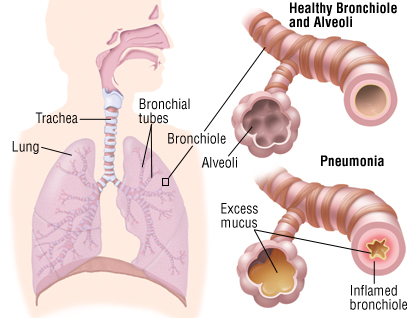

# Computer Vision


Computer vision is an interdisciplinary scientific field that deals with how computers can gain a high-level understanding from digital images or videos. From the perspective of engineering, it seeks to understand and automate tasks that the human visual system can do.
We can use Computer Vision to determine whether a person is affected by pneumonia or not.

# Pneumonia Detection with Convolutional Neural Networks
Computer Vision can be realized using Convolutional neural networks (CNN) They are neural networks making features extraction over an image before classifying it. The feature extraction performed consists of three basic operations:

* Filter an image for a particular feature (convolution)
* Detect that feature within the filtered image (using the ReLU activation)
* Condense the image to enhance the features (maximum pooling)

# The convolution process is illustrated below

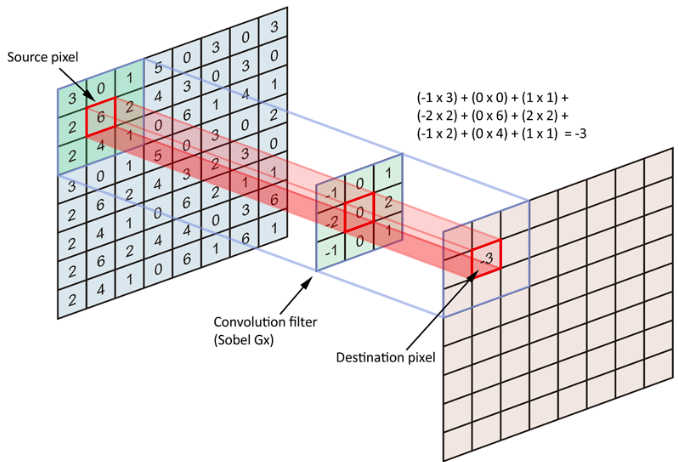

Using convolution filters with different dimensions or values results in differents features extracted

Features are then detected using the reLu activation on each destination pixel.

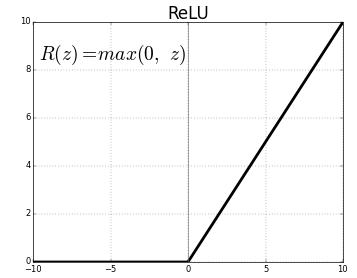

Features are the enhanced with MaxPool layers
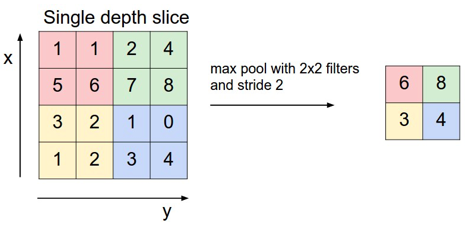

The stride parameters determines the distance between each filters. The padding one determines if we ignore the borderline pixels or not (adding zeros helps the neural network to get information on the border)

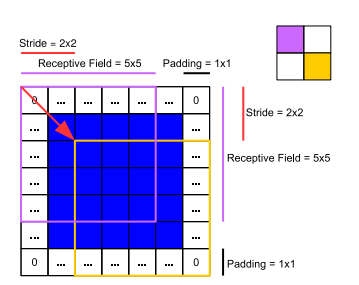

The outputs are then concatened in Dense layers

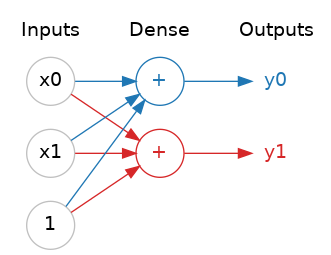

By using a sigmoid activation, the neural network determines which class the image belongs to
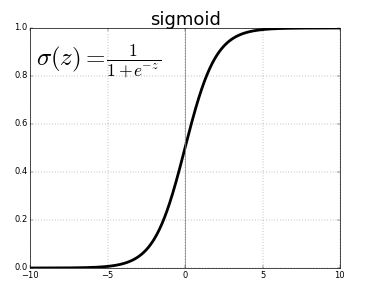

#  Import Packages and Functions
We'll make use of the following packages:

* numpy and pandas is what we'll use to manipulate our data
* matplotlib.pyplot and seaborn will be used to produce plots for visualization
* util will provide the locally defined utility functions that have been provided for this assignment
We will also use several modules from the keras framework for building deep learning models.

Run the next cell to import all the necessary packages.



In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

os.listdir("../input/chest-xray-pneumonia/chest_xray")

['chest_xray', '__MACOSX', 'val', 'test', 'train']

In [2]:
len(os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"))

3875

The dataset is divided into three sets: 1) Train set 2) Validation set and 3) Test set.

# Data Visualization


Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


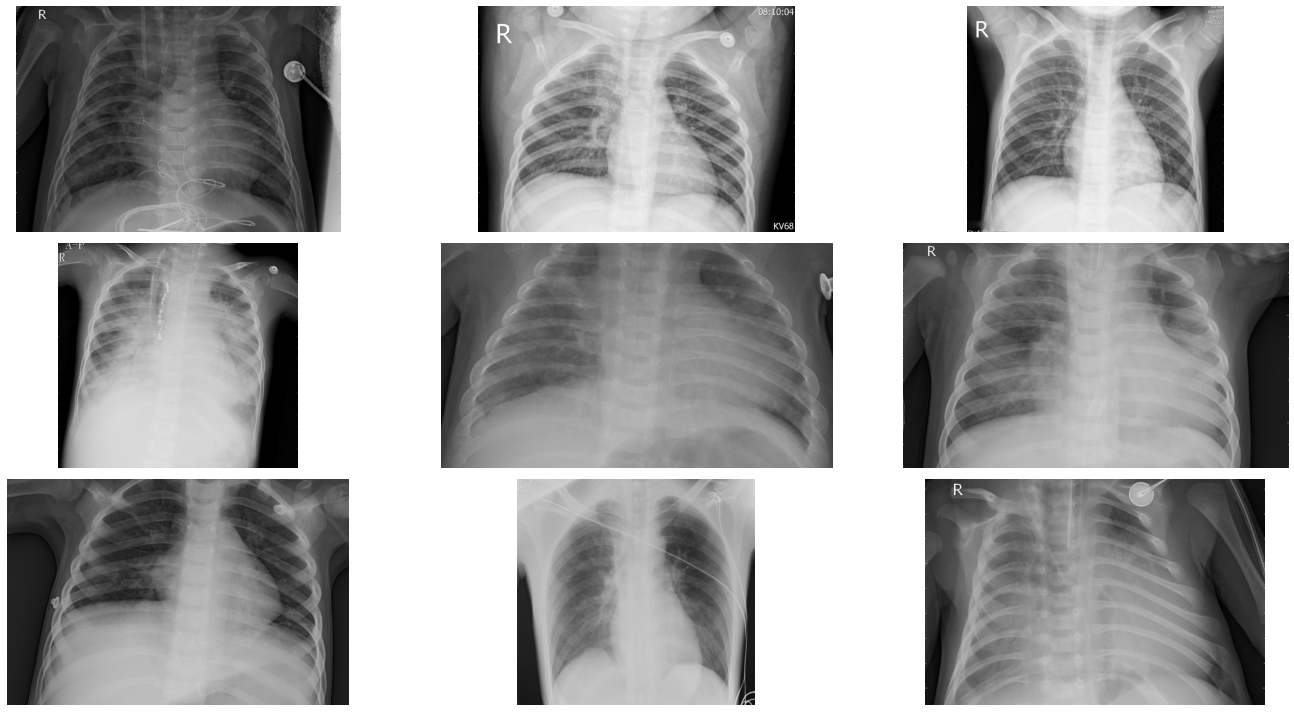

In [3]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

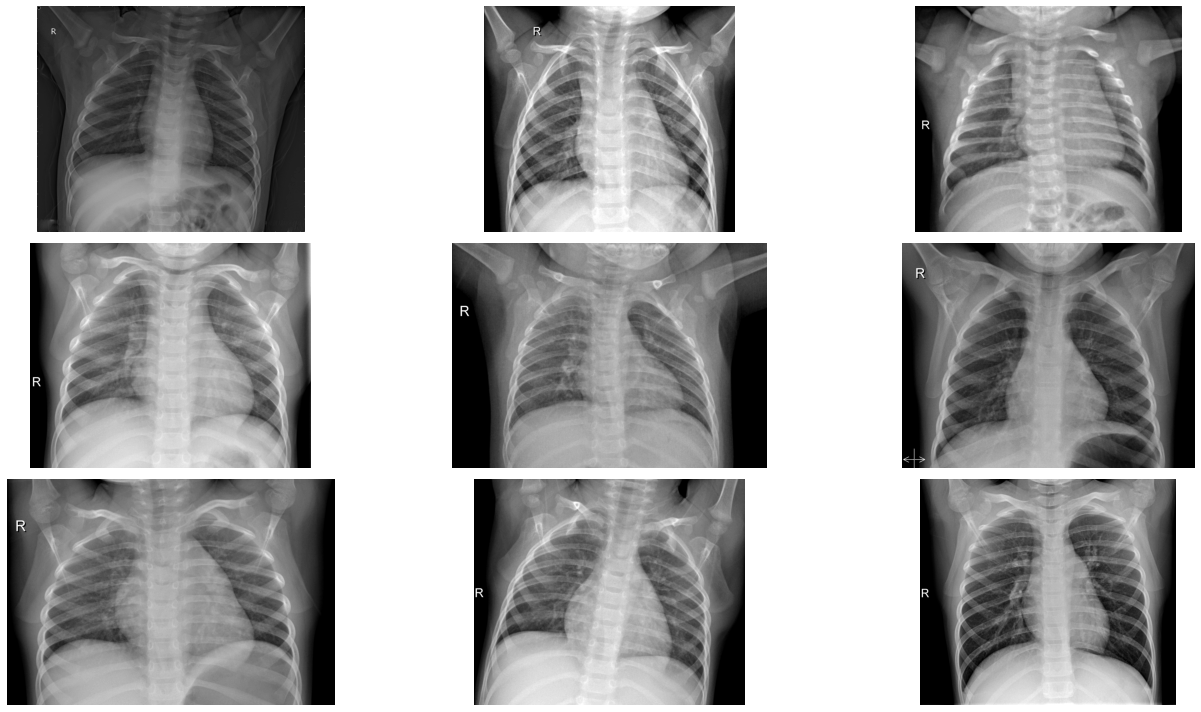

In [4]:
normal = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

The dimensions of the image are 1128 pixels width and 1336 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 73.2978 and the standard deviation is 38.1653


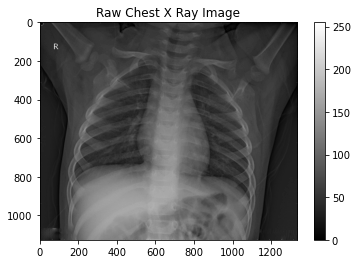

In [5]:
normal_img = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")[0]
normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

# Ivestigate pixel value distribution

Text(0, 0.5, '# Pixels in Image')

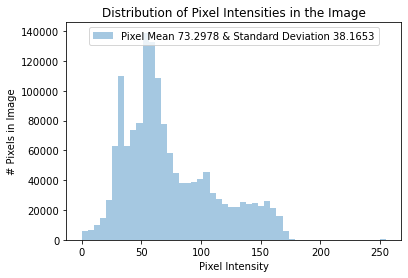

In [6]:
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# 2. Image Preprocessing
Before training, we'll first modify your images to be better suited for training a convolutional neural network. For this task we'll use the Keras ImageDataGenerator function to perform data preprocessing and data augmentation.

This class also provides support for basic data augmentation such as random horizontal flipping of images.
We also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will faciliate model training by standardizing the input distribution).
The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels (we will want this because the pre-trained model that we'll use requires three-channel inputs).

In [7]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Build a separate generator fo valid and test sets

Now we need to build a new generator for validation and t esting data.

Why can't use the same generator as for the training data?

Look back at the generator we wrote for the training data.

It normalizes each image per batch, meaning thatit uses batch statistics.
We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time).
Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data).
What we need to do is to normalize incomming test data using the statistics computed from the training set.

In [8]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 2.8855 and the minimum is -2.2819
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


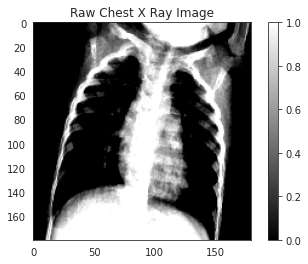

In [9]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

Text(0, 0.5, '# Pixels in Image')

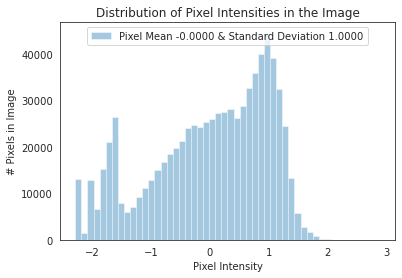

In [10]:
sns.distplot(generated_image.ravel(),
            label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# Building a CNN model

## Impact of imbalance data on loss function

Loss Function:
$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

We can rewrite the the overall average cross-entropy loss over the entire training set `D` of size `N` as follows:
$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$



When we have an imbalance data, using a normal loss function will result a model that bias toward the dominating class. One solution is to use a weighted loss function. Using weighted loss function will balance the contribution in the loss function.

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [11]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [12]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 178, 178, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 176, 176, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 86, 86, 64)        2

In [14]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 22s 221ms/step - loss: 1.0302 - accuracy: 0.8075 - val_loss: 47.6744 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 20s 205ms/step - loss: 0.2636 - accuracy: 0.8275 - val_loss: 58.9051 - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 19s 193ms/step - loss: 0.1774 - accuracy: 0.8500 - val_loss: 11.9920 - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 20s 195ms/step - loss: 0.1473 - accuracy: 0.8675 - val_loss: 8.3084 - val_accuracy: 0.5000
Epoch 5/10
100/100 [==============================] - 18s 185ms/step - loss: 0.1619 - accuracy: 0.8813 - val_loss: 1.1438 - val_accuracy: 0.5625
Epoch 6/10
100/100 [==============================] - 19s 188ms/step - loss: 0.1226 - accuracy: 0.8800 - val_loss: 1.3685 - val_accuracy: 0.6875
Epoch 7/10
100/100 [==============================] - 18s 179ms/step - loss: 0.1062 - accuracy: 0.9000 - val_loss: 0.2966 - val

Text(0.5, 1.0, 'Accuracy Evolution')

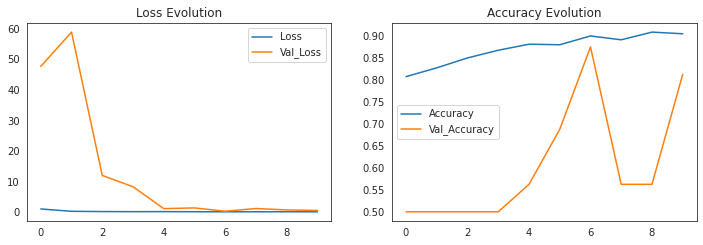

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [16]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 14s 23ms/step - loss: 0.4296 - accuracy: 0.8462
Test Accuracy: 84.62%
652/652 [==============================] - 103s 159ms/step - loss: 0.3312 - accuracy: 0.8969
Train Accuracy: 89.69%


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

[[181  53]
 [ 46 344]]


,0,1,accuracy,macro avg,weighted avg
precision,0.797357,0.866499,0.841346,0.831928,0.840571
recall,0.773504,0.882051,0.841346,0.827778,0.841346
f1-score,0.785249,0.874206,0.841346,0.829728,0.840847
support,234.000000,390.000000,0.841346,624.000000,624.000000


In [18]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[200  34]
 [ 81 309]]


,0,1,accuracy,macro avg,weighted avg
precision,0.711744,0.900875,0.815705,0.806309,0.829951
recall,0.854701,0.792308,0.815705,0.823504,0.815705
f1-score,0.776699,0.843111,0.815705,0.809905,0.818206
support,234.000000,390.000000,0.815705,624.000000,624.000000


# Transfer Learning
# DenseNet
Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network:

* The first layer is connected to the 2nd, 3rd, 4th etc.
* The second layer is conected to the 3rd, 4th, 5th etc.

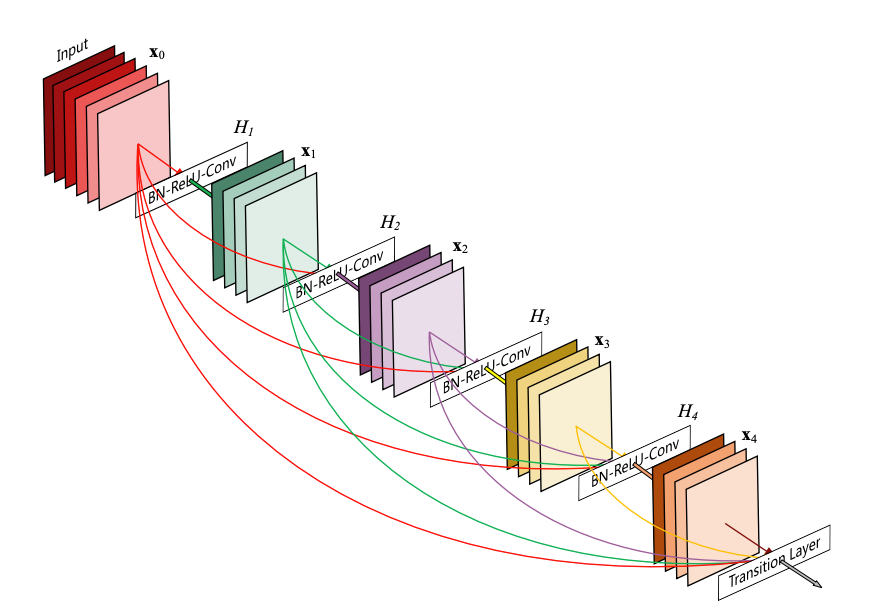

for more information about the DenseNet Architecture visit this website : https://keras.io/api/applications/densenet/


In [19]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 90, 90, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1/conv[0][0]                 
_______________________

In [20]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [21]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape Tensor("input_1:0", shape=(None, 180, 180, 3), dtype=float32)
The output shape Tensor("avg_pool/Identity:0", shape=(None, 1024), dtype=float32)


In [22]:

#model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [23]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 21s 207ms/step - loss: 0.1705 - accuracy: 0.8275 - val_loss: 8.3540 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 17s 169ms/step - loss: 0.1189 - accuracy: 0.8725 - val_loss: 2.6481 - val_accuracy: 0.6250
Epoch 3/10
100/100 [==============================] - 18s 179ms/step - loss: 0.0975 - accuracy: 0.8875 - val_loss: 1.5859 - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 18s 176ms/step - loss: 0.1059 - accuracy: 0.8988 - val_loss: 0.9687 - val_accuracy: 0.5625
Epoch 5/10
100/100 [==============================] - 18s 179ms/step - loss: 0.0798 - accuracy: 0.9112 - val_loss: 1.3149 - val_accuracy: 0.6875
Epoch 6/10
100/100 [==============================] - 19s 187ms/step - loss: 0.0721 - accuracy: 0.9212 - val_loss: 2.3806 - val_accuracy: 0.5000
Epoch 7/10
100/100 [==============================] - 17s 171ms/step - loss: 0.1056 - accuracy: 0.8975 - val_loss: 0.8888 - val_ac

Text(0.5, 1.0, 'Accuracy Evolution')

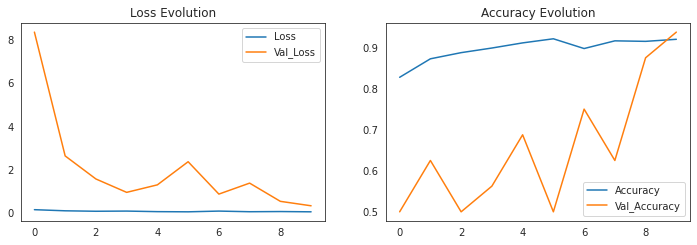

In [24]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [25]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 15s 24ms/step - loss: 0.3812 - accuracy: 0.8446
Test Accuracy: 84.46%
652/652 [==============================] - 97s 148ms/step - loss: 0.2113 - accuracy: 0.9245
Train Accuracy: 92.45%


# Evaluation

In [26]:
predicted_vals = model.predict(test, steps=len(test))

In [27]:
print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

[[175  59]
 [ 42 348]]


,0,1,accuracy,macro avg,weighted avg
precision,0.806452,0.855037,0.838141,0.830744,0.836817
recall,0.747863,0.892308,0.838141,0.820085,0.838141
f1-score,0.776053,0.873275,0.838141,0.824664,0.836817
support,234.000000,390.000000,0.838141,624.000000,624.000000


# VGG16
Presented in 2014, VGG16 has a very simple and classical architecture, with blocks of 2 or 3 convolutional layers followed by a pooling layer, plus a final dense network composed of 2 hidden layers (of 4096 nodes each) and one output layer (of 1000 nodes). Only 3x3 filters are used.

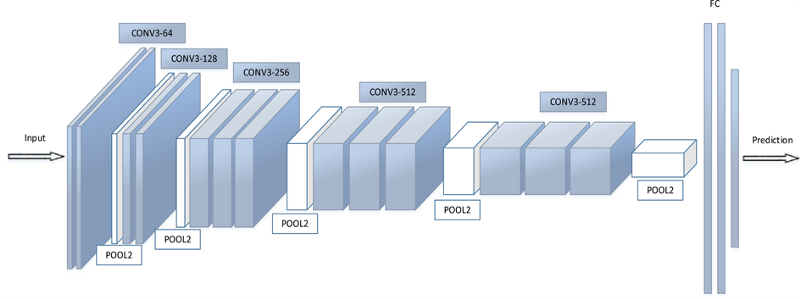

In [28]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16


vgg16_base_model = VGG16(input_shape=(180,180,3),include_top=False,weights='imagenet')

    


58892288/58889256 [==============================] - 1s 0us/step


In [29]:
vgg16_base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [30]:


    vgg16_model = tf.keras.Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

In [31]:
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    vgg16_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [32]:
r = vgg16_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)



Epoch 1/10
100/100 [==============================] - 17s 171ms/step - loss: 0.2456 - accuracy: 0.6750 - precision: 0.8983 - recall: 0.6231 - val_loss: 8.8623 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 18s 176ms/step - loss: 0.2209 - accuracy: 0.7113 - precision: 0.9064 - recall: 0.6949 - val_loss: 7.7409 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 16s 160ms/step - loss: 0.2153 - accuracy: 0.7337 - precision: 0.9087 - recall: 0.7097 - val_loss: 0.7526 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.1250
Epoch 4/10
100/100 [==============================] - 18s 178ms/step - loss: 0.1775 - accuracy: 0.7887 - precision: 0.9350 - recall: 0.7637 - val_loss: 2.8258 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 164ms/step - loss:

Text(0.5, 1.0, 'Accuracy Evolution')

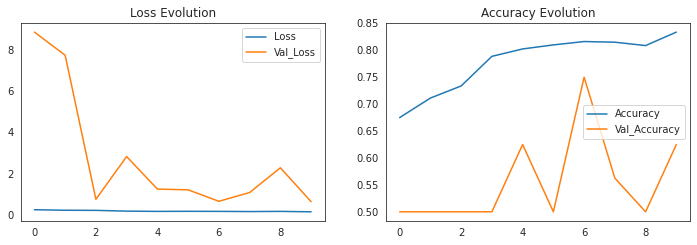

In [33]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [34]:
evaluation =vgg16_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = vgg16_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 13s 21ms/step - loss: 0.8073 - accuracy: 0.6571 - precision: 0.9272 - recall: 0.4897
Test Accuracy: 65.71%
652/652 [==============================] - 99s 152ms/step - loss: 0.9043 - accuracy: 0.6181 - precision: 0.9963 - recall: 0.4877
Train Accuracy: 61.81%


# ResNet

See the full explanation and schemes in the Research Paper on Deep Residual Learning (https://arxiv.org/pdf/1512.03385.pdf)

In [35]:
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights='imagenet')



94773248/94765736 [==============================] - 1s 0us/step


In [36]:
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 90, 90, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [37]:
    resnet_model = tf.keras.Sequential([
        resnet_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [38]:
r = resnet_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)


Epoch 1/10
100/100 [==============================] - 18s 175ms/step - loss: 0.2575 - accuracy: 0.6625 - precision: 0.8758 - recall: 0.6486 - val_loss: 5.4126 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 18s 180ms/step - loss: 0.2642 - accuracy: 0.6662 - precision: 0.8556 - recall: 0.6650 - val_loss: 0.6702 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 3/10
100/100 [==============================] - 16s 163ms/step - loss: 0.1924 - accuracy: 0.7713 - precision: 0.9170 - recall: 0.7613 - val_loss: 0.9461 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
100/100 [==============================] - 18s 184ms/step - loss: 0.1954 - accuracy: 0.8000 - precision: 0.9138 - recall: 0.7958 - val_loss: 1.2042 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/10
100/100 [==============================] - 17s 168ms/step - loss: 0.1631 

Text(0.5, 1.0, 'Accuracy Evolution')

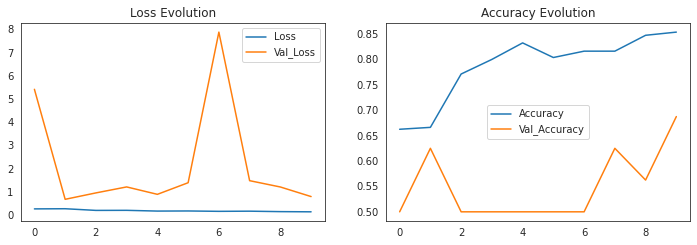

In [39]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [40]:
evaluation =resnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = resnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 14s 22ms/step - loss: 0.5498 - accuracy: 0.8173 - precision: 0.8966 - recall: 0.8000
Test Accuracy: 81.73%
652/652 [==============================] - 101s 154ms/step - loss: 0.6139 - accuracy: 0.8196 - precision: 0.9893 - recall: 0.7654
Train Accuracy: 81.96%


# InceptionNet
Also known as GoogleNet, this architecture presents sub-networks called inception modules, which allows fast training computing, complex patterns detection, and optimal use of parameters

for more information visit https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf



In [41]:
from keras.applications import InceptionV3

inception_base_model = InceptionV3(input_shape=(180,180,3),include_top=False,weights='imagenet')



87916544/87910968 [==============================] - 1s 0us/step


In [42]:
    inception_model = tf.keras.Sequential([
        inception_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    inception_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [43]:
r = inception_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)


Epoch 1/10
100/100 [==============================] - 18s 182ms/step - loss: 0.2331 - accuracy: 0.7113 - precision: 0.8994 - recall: 0.6954 - val_loss: 0.4899 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 2/10
100/100 [==============================] - 19s 191ms/step - loss: 0.1994 - accuracy: 0.7850 - precision: 0.9289 - recall: 0.7694 - val_loss: 8.5411 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 16s 158ms/step - loss: 0.1820 - accuracy: 0.7763 - precision: 0.9300 - recall: 0.7635 - val_loss: 12.8820 - val_accuracy: 0.6250 - val_precision: 0.7500 - val_recall: 0.3750
Epoch 4/10
100/100 [==============================] - 20s 195ms/step - loss: 0.1638 - accuracy: 0.8062 - precision: 0.9461 - recall: 0.7874 - val_loss: 2.0006 - val_accuracy: 0.3125 - val_precision: 0.3333 - val_recall: 0.3750
Epoch 5/10
100/100 [==============================] - 16s 165ms/step - loss: 0.1921

Text(0.5, 1.0, 'Accuracy Evolution')

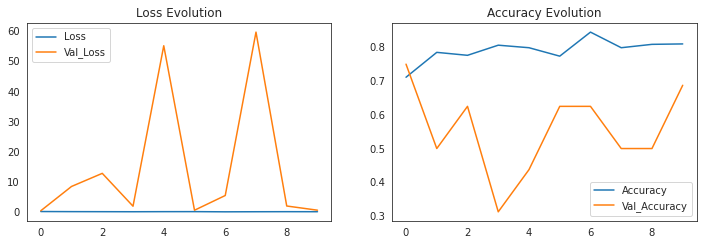

In [44]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [45]:
evaluation =inception_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = inception_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 16s 25ms/step - loss: 0.6258 - accuracy: 0.7051 - precision: 0.9120 - recall: 0.5846
Test Accuracy: 70.51%
652/652 [==============================] - 103s 159ms/step - loss: 0.6924 - accuracy: 0.6904 - precision: 0.9922 - recall: 0.5879
Train Accuracy: 69.04%
